<a href="https://colab.research.google.com/github/hskim-py/REPS_Low_Frequency_NVH_Post/blob/main/Ansys_motion_post_result_RBNA_Low_frequency_NVH_FFT_25r2_Input%EC%A0%95%EC%9E%85%EB%A0%A5_%EC%A1%B0%EA%B1%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

기존에 Nut 강제변위 조건에서
Input Shaft 강제 변위 및 Nut TQ 조건으로 변경
축하중 8000N, Nut TQ 7800Nmm

변경 사유는 Pinion의 전치/후치 여부에 따라 저주파 Screw 경향 차이 발생
Rack rolling TQ 방향의 영향성이 의심됨

In [2]:
# Refer to the ResultFileReaderAPI.py file
import sys

# The current_dir variable indicates the directory of the current file.
# You must add the path to the folder containing 'ResultFileReaderAPI.py' to this current director path.
#current_dir = __file__.rsplit('\\', 1)[0]
#external_modules_path = current_dir + "\\Modules"
#sys.path.append(external_modules_path)

sys.path.append(r'C:\Program Files\ANSYS Inc\v252\Motion\Document\Postprocessor API for Python\Postprocessor API for Python')

from ResultFileReaderAPI import *
# Example_ResultFileReaderAPI.py
from ResultFileReaderAPI import *
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import numpy as np # Import numpy for interpolation

In [35]:
import pandas as pd

def calculate_bandsum(xf, yf, freq_low, freq_high):
    yf_power = ((yf/0.7071)**2)/1.5

    #xf, yf를 pandas dataframe으로 생성, xf, yf는 np array
    df = pd.DataFrame({'xf': xf, 'yf': yf})
    df['yf_power'] = yf_power


    #df 중에 xf가 200~400 구간 안에 있는 yf 값만 더함
    df_filtered = df[(df['xf']>=freq_low) & (df['xf']<=freq_high)]
    bandsum = df_filtered['yf_power'].sum()**0.5 * 0.7071
    peak = df_filtered['yf'].max()
    xf_peak = df.loc[df['yf'] == peak, 'xf'].iloc[0]
    #peak 를 소숫점 4 자리까지 표현
    print(f'peak = {round(peak,2)}mm/s2 @{round(xf_peak,2)}Hz')
    #yf 값이 peak인 xf 값

    return bandsum




In [36]:


def analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time):
    # Import result file
    outputReader = OutputReader(file_path)

    # Get Curves
    paths = List[str]()
    for path in paths_list:
        paths.Add(path)

    plotParameter = PlotParameters()
    plotParameter.Target = target
    plotParameter.Paths = paths
    plotParameter.PlotDataType = PlotDataType.PlotResult
    plotParameter.AutoDecimation = False

    results = outputReader.GetCurves(plotParameter)

    time = []
    Acc_x = []
    Acc_y = []
    Acc_z = []

    for kvp in results:
        path_name = kvp.Key
        points = kvp.Value

        if not time:
            for pt in points:
                time.append(pt.X)

        if "/Acceleration/X" in path_name:
            for pt in points:
                Acc_x.append(pt.Y)

        if "/Acceleration/Y" in path_name:
            for pt in points:
                Acc_y.append(pt.Y)

        if "/Acceleration/Z" in path_name:
            for pt in points:
                Acc_z.append(pt.Y)

    # Close
    outputReader.Close()

    #subplot으로 time에 대한 Acc_x, Acc_y, Acc_z 가로로 표현
    #subplot 배치를 가로로 설정
    #fig, axs = plt.subplots(1, 3, sharey=False, figsize=(18, 5)) # Increased width to 18 (3 times the default width of 6)
    #axs[0].plot(time, Acc_x)
    #axs[0].set_title('Acc_x')
    #axs[1].plot(time, Acc_y)
    #axs[1].set_title('Acc_y')
    #axs[2].plot(time, Acc_z)
    #axs[2].set_title('Acc_z')

    # Function to display cursor coordinates
    def on_move(event):
        if event.inaxes:
            # Get the coordinates in data space
            x, y = event.xdata, event.ydata
            print(f'x: {x:.4f}, y: {y:.4f}')


    # Connect the motion_notify_event to the on_move function for the first plot
    #fig.canvas.mpl_connect('motion_notify_event', on_move)


    #plt.show()

    # Select data within the 0.1s to 1s range
    start_time = FFT_start_time
    end_time = FFT_end_time

    # Create a list of acceleration data
    acceleration_data = [Acc_x, Acc_y, Acc_z]
    acceleration_labels = ['Acc_x', 'Acc_y', 'Acc_z']

    # Arrange subplots horizontally (1 row, 3 columns) and increase the figure size
    fig2, axs = plt.subplots(1, 3, sharey=False, figsize=(18, 5))

    for i, acc_data in enumerate(acceleration_data):

        print(i)

        # Find indices within the desired time range
        indices = [j for j, t in enumerate(time) if start_time <= t <= end_time]

        # Extract the corresponding time and acceleration values
        time_subset = [time[j] for j in indices]
        acc_subset = [acc_data[j] for j in indices]

        # Since the time interval is not uniform, interpolate the data to create a uniformly sampled signal for FFT
        # First, create a uniformly spaced time vector
        num_points = len(time_subset)
        time_uniform = np.linspace(time_subset[0], time_subset[-1], num_points)

        # Interpolate acc_subset onto the uniform time vector
        acc_uniform = np.interp(time_uniform, time_subset, acc_subset)

        # Calculate the sampling frequency assuming the interpolated data is uniformly sampled
        # dt is the average time difference in the original subset
        dt = np.mean(np.diff(time_subset))

        # Perform FFT
        yf = fft(acc_uniform)
        y_fft = 2.0 / num_points * np.abs(yf[0:num_points // 2])
        xf = fftfreq(num_points, dt)[:num_points // 2]

        #100~200 Bandsum
        #bandsum_100_200 = calculate_bandsum(xf, y_fft, 100, 200)
        #print(f"bandsum (100~200Hz) = {round(bandsum_100_200,2)}")

        #130~160 Bandsum
        bandsum_130_160 = calculate_bandsum(xf, y_fft, 130, 160)
        print(f"bandsum (130~160Hz) = {round(bandsum_130_160,2)}")


        # Plot the FFT results on the corresponding subplot
        axs[i].plot(xf, y_fft)
        axs[i].set_title(f'FFT of {acceleration_labels[i]}')
        axs[i].set_xlim(0, 1000)
        axs[i].set_ylim(0, 1500)  # Set y-axis limit to 0-2000 as requested

    # Connect the motion_notify_event to the on_move function for the second figure
    fig2.canvas.mpl_connect('motion_notify_event', on_move)

    #plt.tight_layout()
    plt.show()

bob1 결과

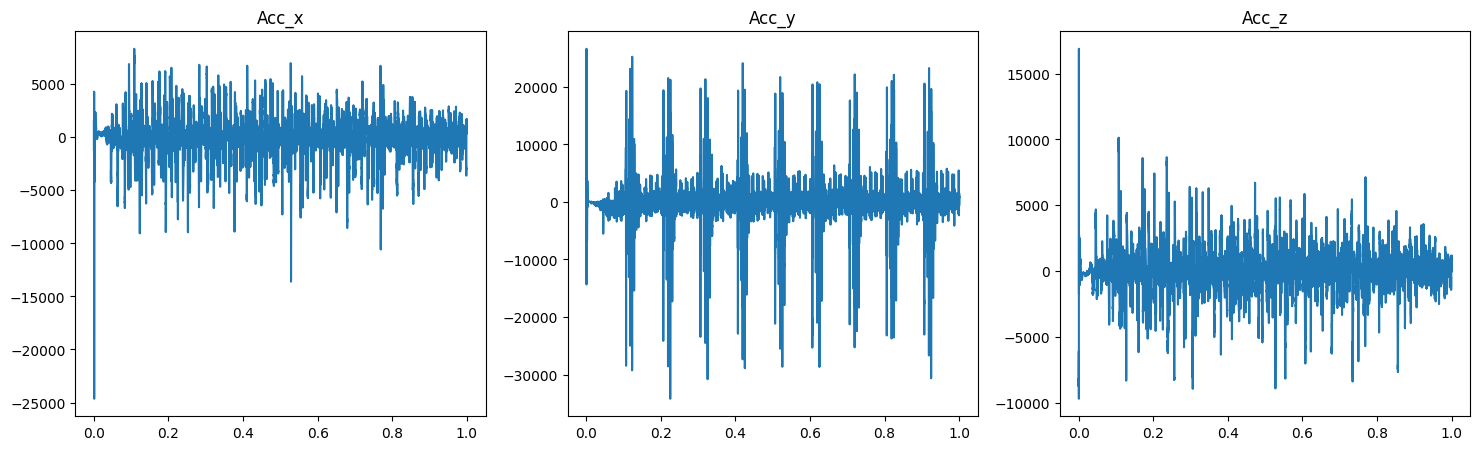

peak = 423.4394
152.222222222239
freq_peak = 152.222222222239
bandsum (100~200Hz) = 1231.0938890547413
peak = 69.0783
125.55555555556938
freq_peak = 125.55555555556938
bandsum (100~200Hz) = 128.74027707837342
peak = 420.24
142.2222222222379
freq_peak = 142.2222222222379
bandsum (100~200Hz) = 1239.7099853299592


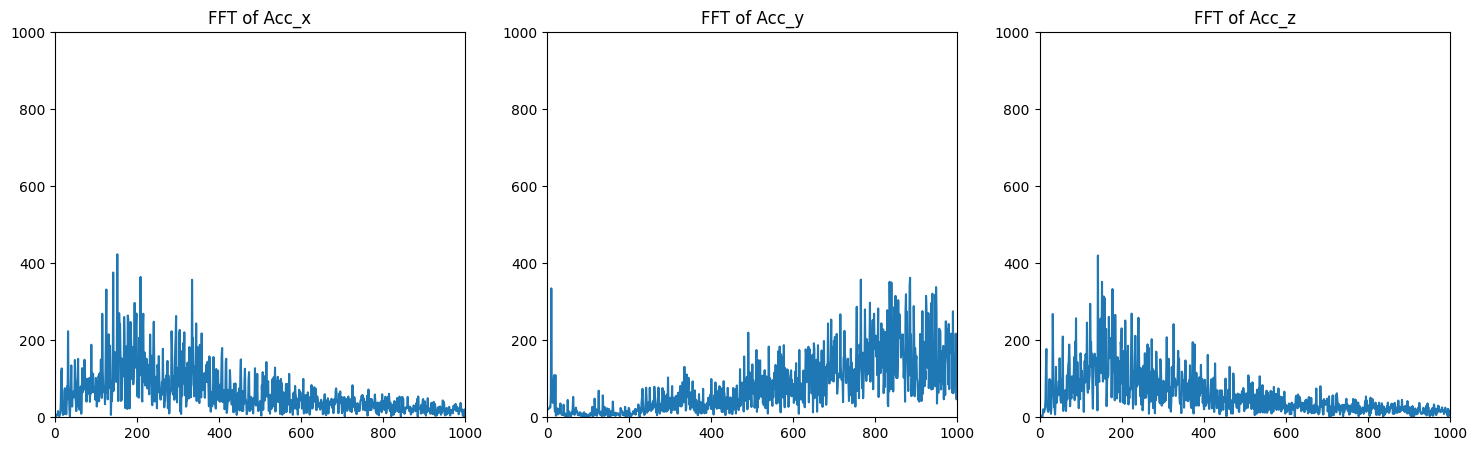

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_688_TQ_BOB1.dfr')
#bob1 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

bob1 결과

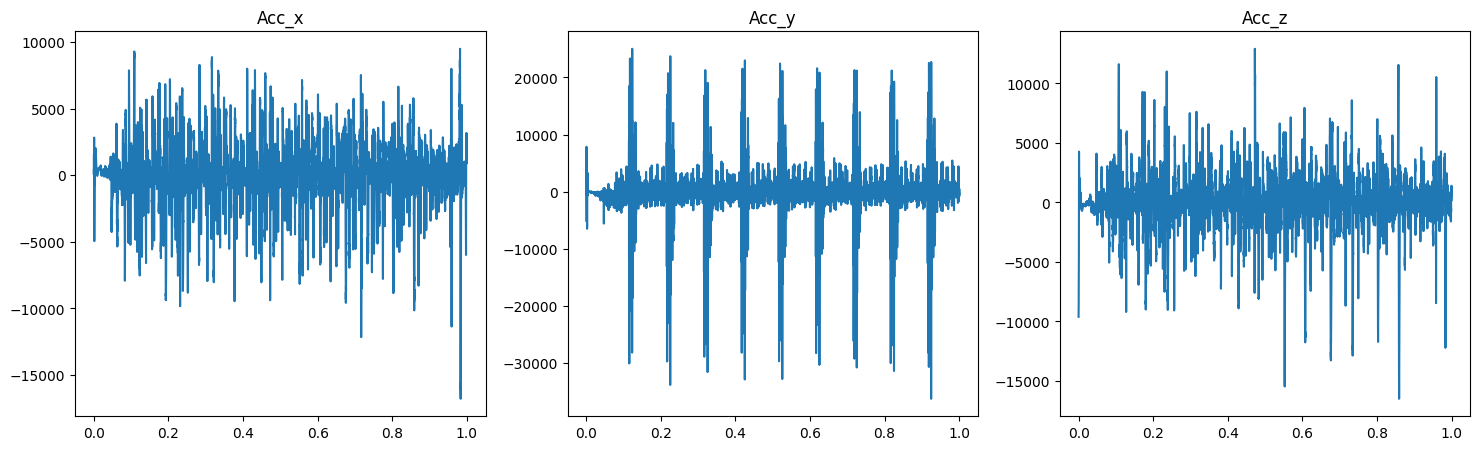

num_points:18000
num_points:18000
num_points:18000


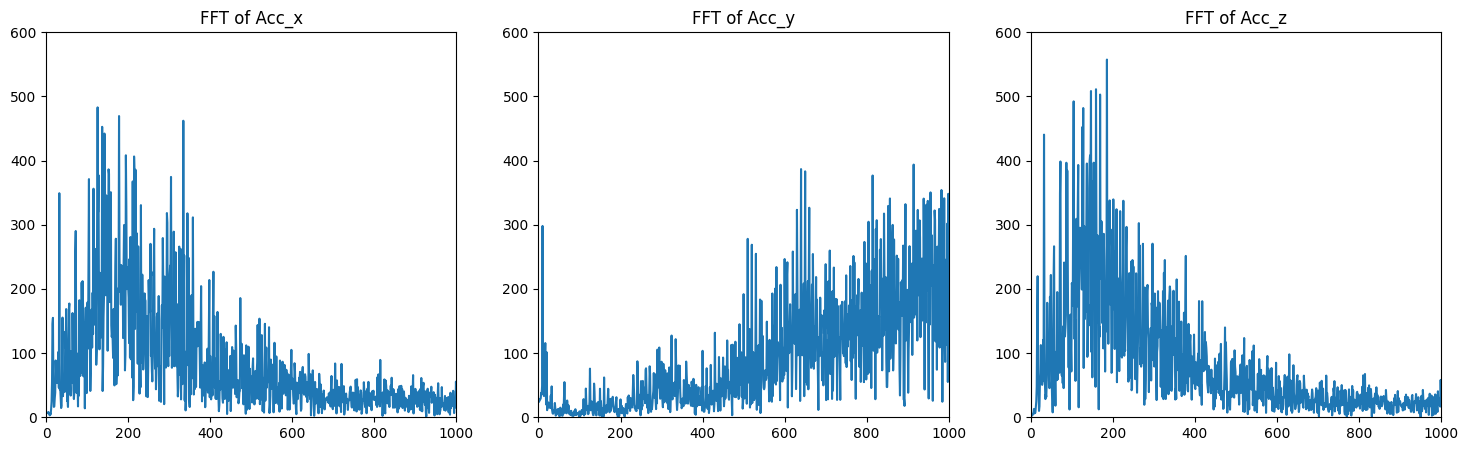

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_788_TQ.dfr')
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

랙바 길이를 변경하면 길이와 비례하여 가속도 peak가 변경됨

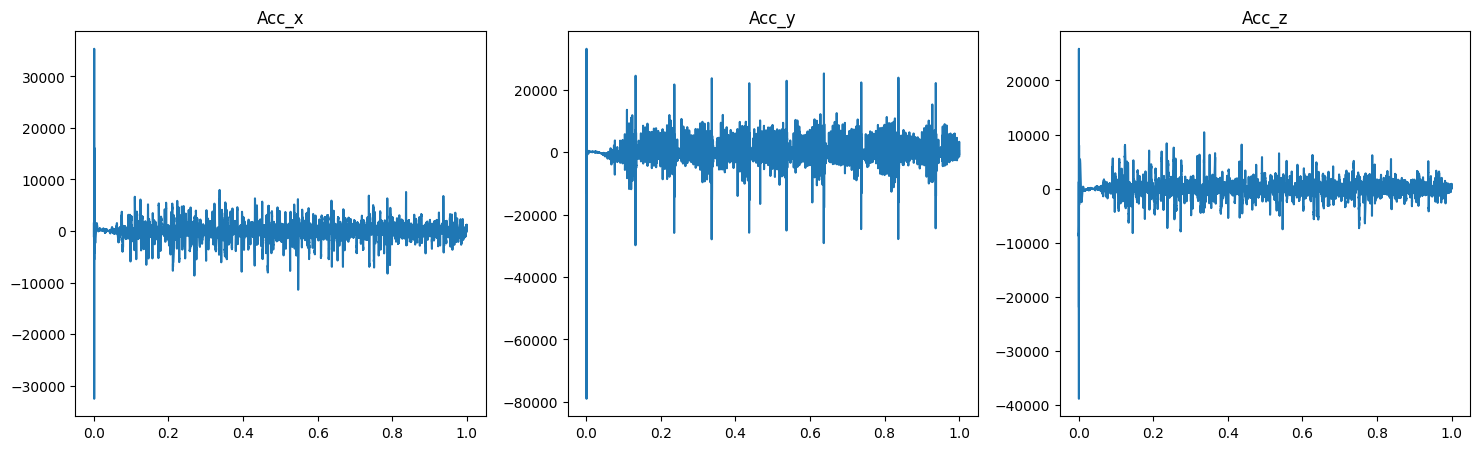

num_points:18000
num_points:18000
num_points:18000


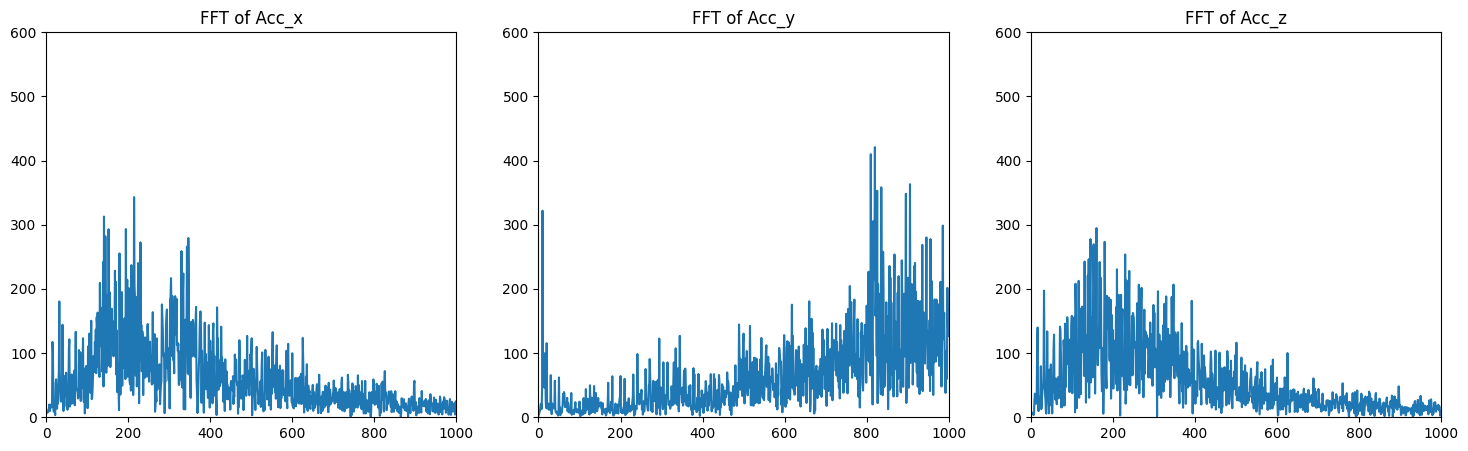

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_688_front_TQ.dfr')
#bob1 결과
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

In [ ]:
후치 구조에 비해 전치구조가 유리함, 롤링 토크 방향에 따라


아래부터 WOW2 결과

1.   전치/후치 비교 - 788mm에서 치방향만 변경
2.   wow2 bob1 비교




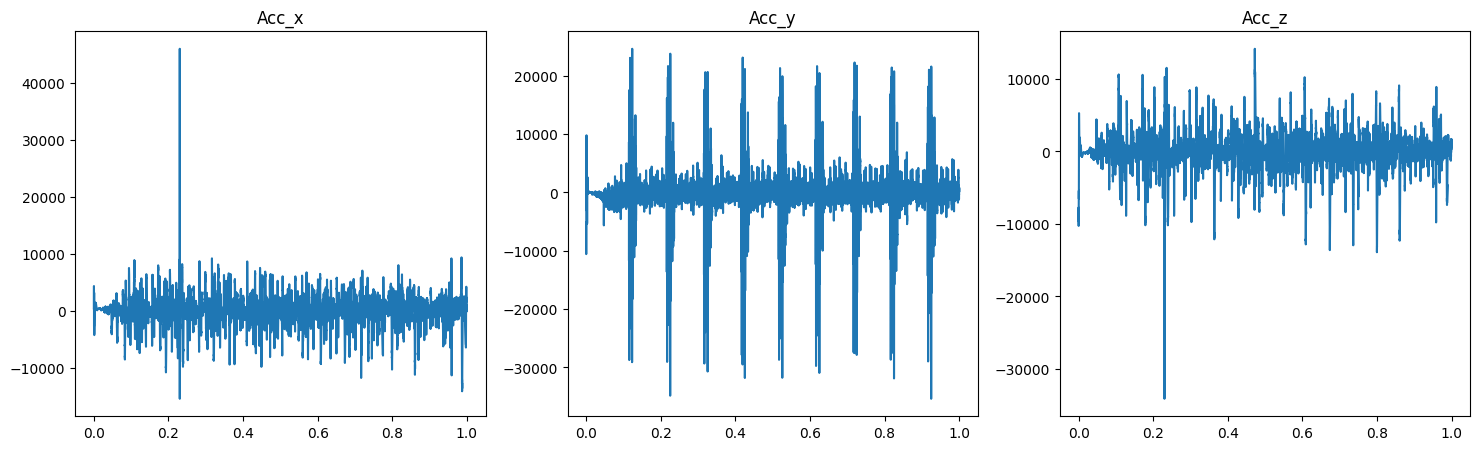

peak = 661.04
freq_peak = 142.23
bandsum (100~200Hz) = 1992.35
peak = 74.38
freq_peak = 125.56
bandsum (100~200Hz) = 156.19
peak = 647.31
freq_peak = 142.23
bandsum (100~200Hz) = 2076.19


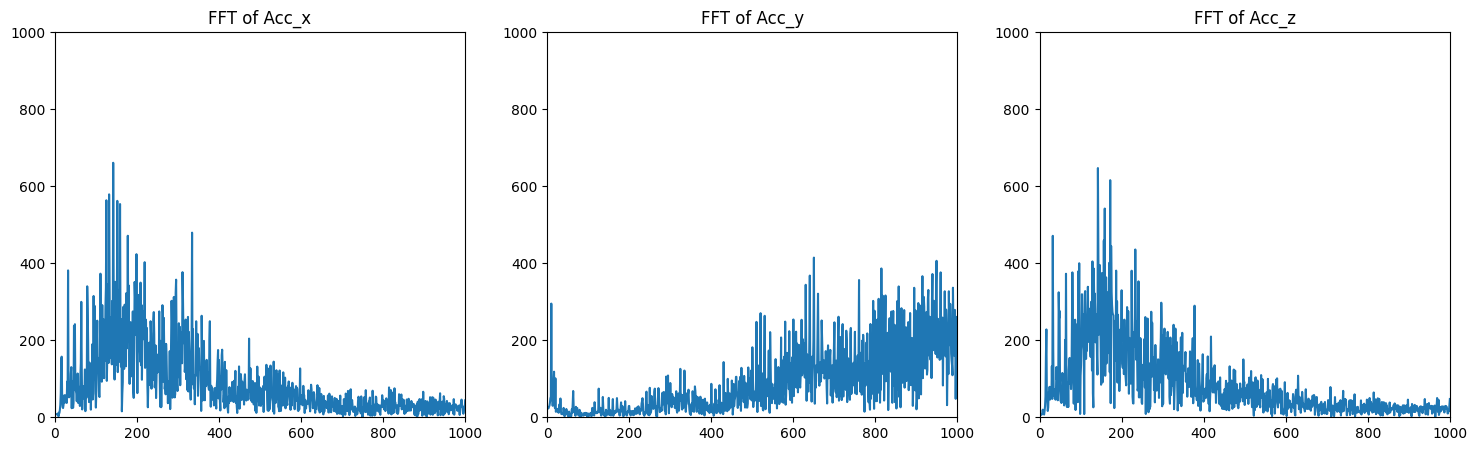

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_788_TQ_WOW2.dfr')
#WOW2결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

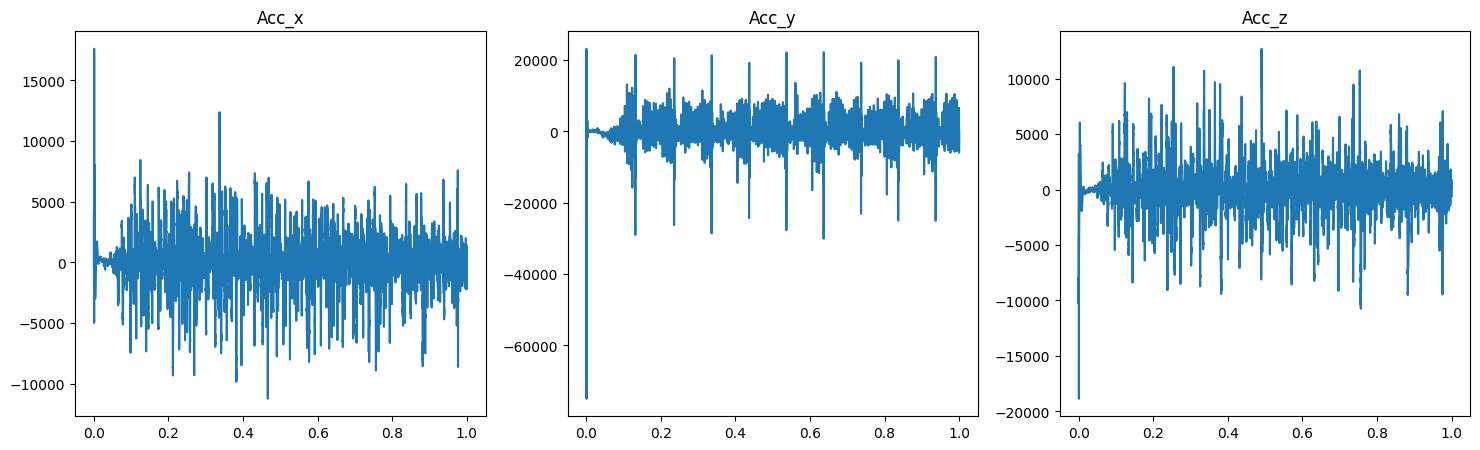

peak = 703.0
freq_peak = 152.22
bandsum (100~200Hz) = 1721.46
peak = 79.49
freq_peak = 180.0
bandsum (100~200Hz) = 158.4
peak = 649.89
freq_peak = 152.22
bandsum (100~200Hz) = 1776.55


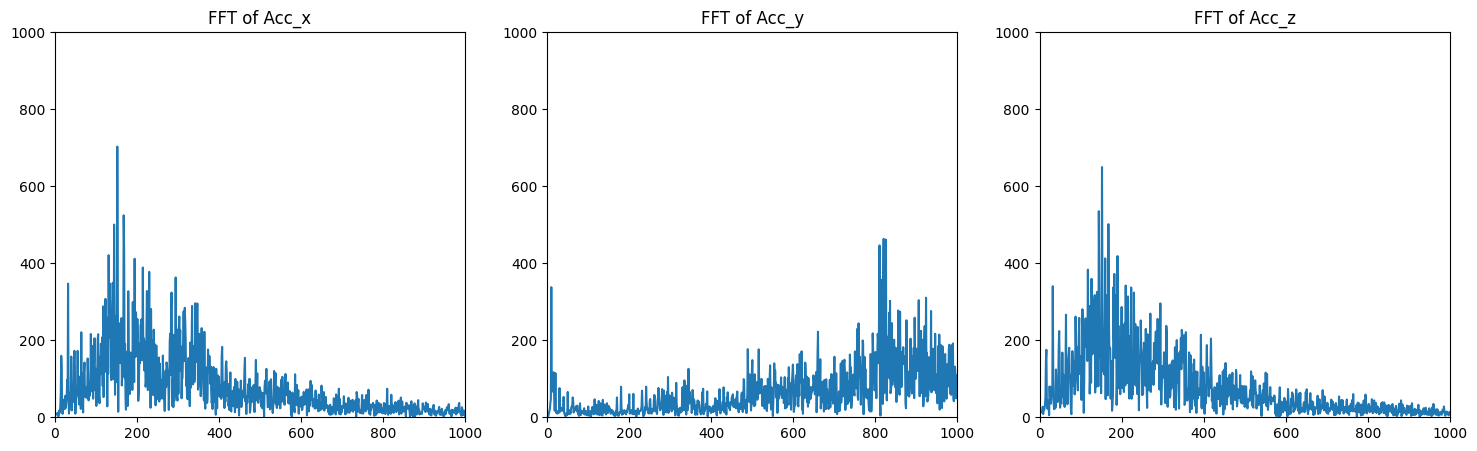

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_788_front_TQ_WOW2.dfr')
#WOW2 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

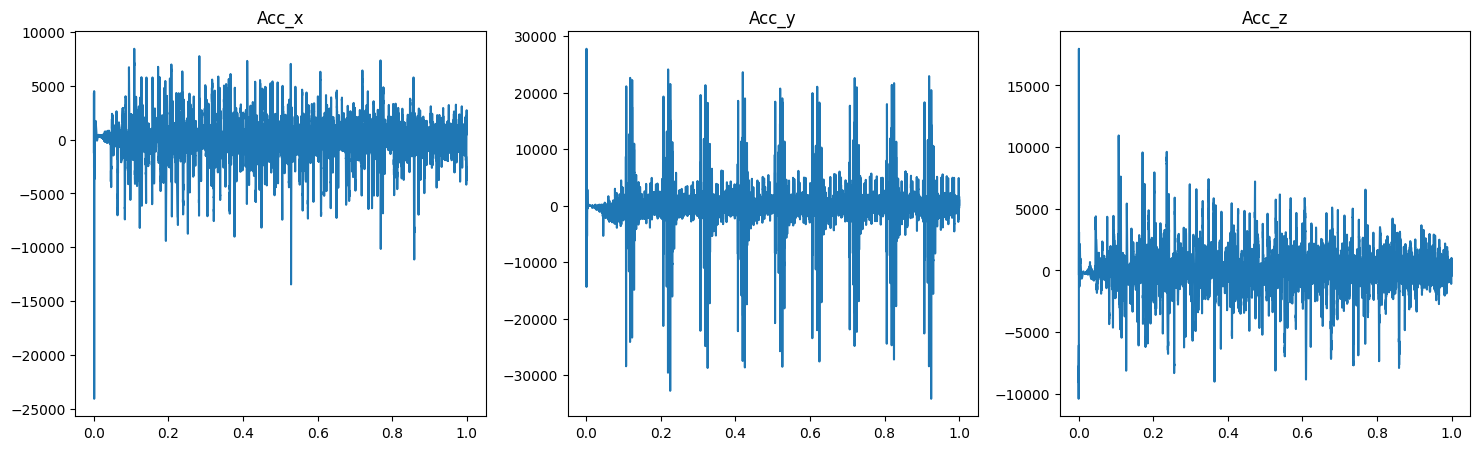

peak = 355.32
freq_peak = 132.23
bandsum (100~200Hz) = 1335.93
peak = 64.19
freq_peak = 125.56
bandsum (100~200Hz) = 132.83
peak = 350.02
freq_peak = 172.23
bandsum (100~200Hz) = 1432.16


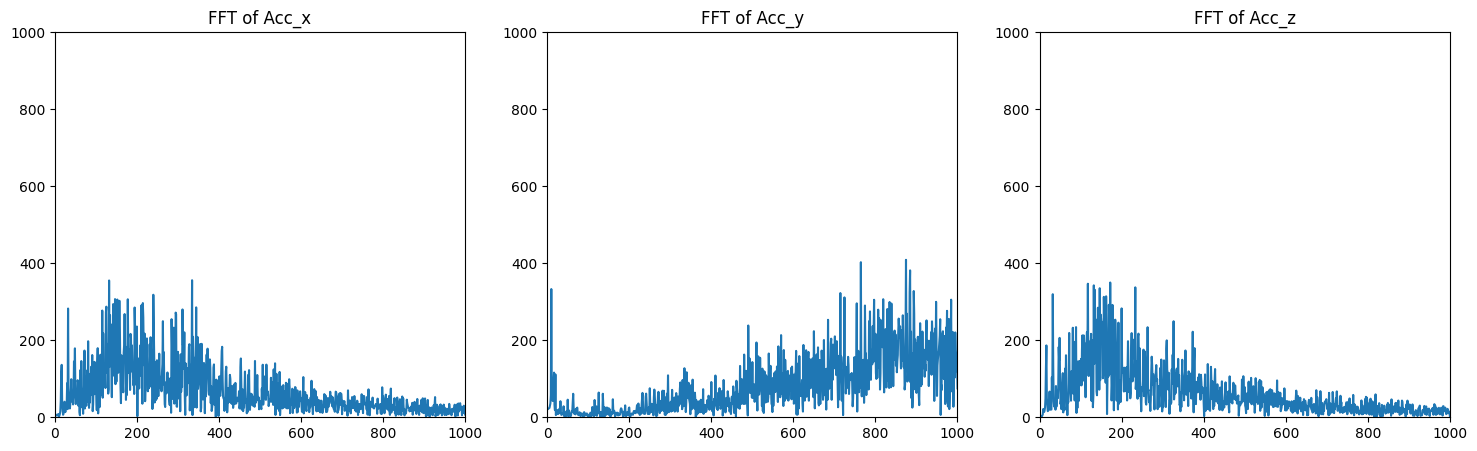

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_688_TQ_WOW2.dfr')
#WOW2 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

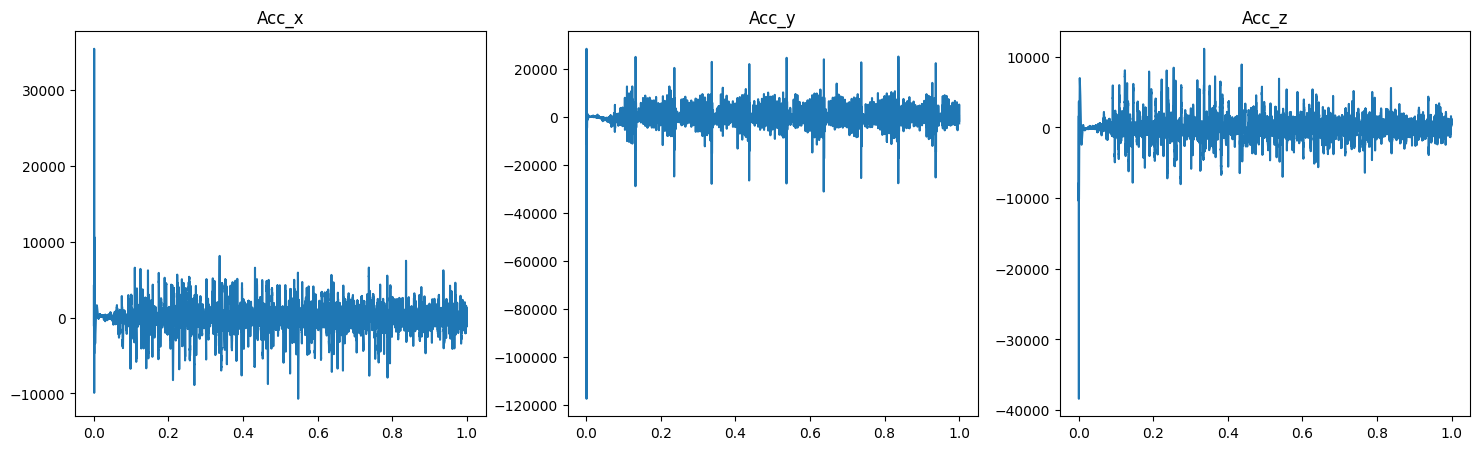

peak = 382.49
freq_peak = 152.23
bandsum (100~200Hz) = 1140.56
peak = 64.83
freq_peak = 180.01
bandsum (100~200Hz) = 151.25
peak = 340.0
freq_peak = 152.23
bandsum (100~200Hz) = 1133.08


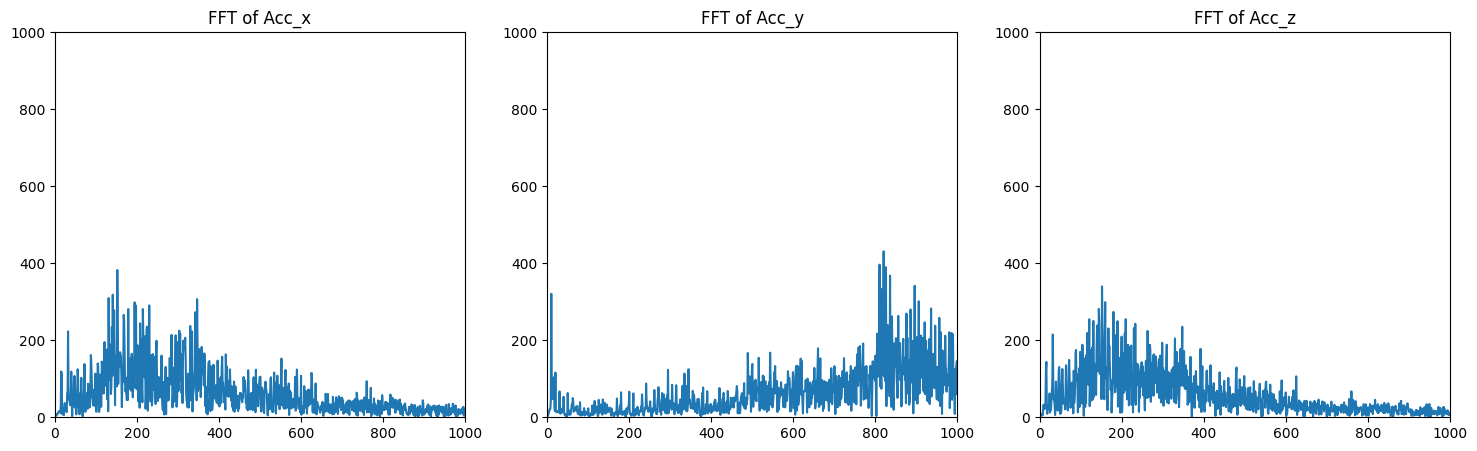

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_no_hsg_688_front_TQ_WOW2.dfr')
#WOW2 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

250916
- JX 해석 결과를 하우징 + Input Speed 60rpm + Nut Torque 8.9Nm 기준으로 다시 정리함
- 하우징 마운팅 축방향 강성 600 --> 6000, 600으로 해석 시 peak 주파수 125  6000으로 해석 시 peak 주파수 140


In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_WOW1_MVA60_TQ.dfr')
#WOW1 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

0
peak = 720.36mm/s2 @142.75Hz
bandsum (130~160Hz) = 1544.39
1
peak = 54.53mm/s2 @150.13Hz
bandsum (130~160Hz) = 107.05
2
peak = 635.34mm/s2 @156.28Hz
bandsum (130~160Hz) = 1332.66


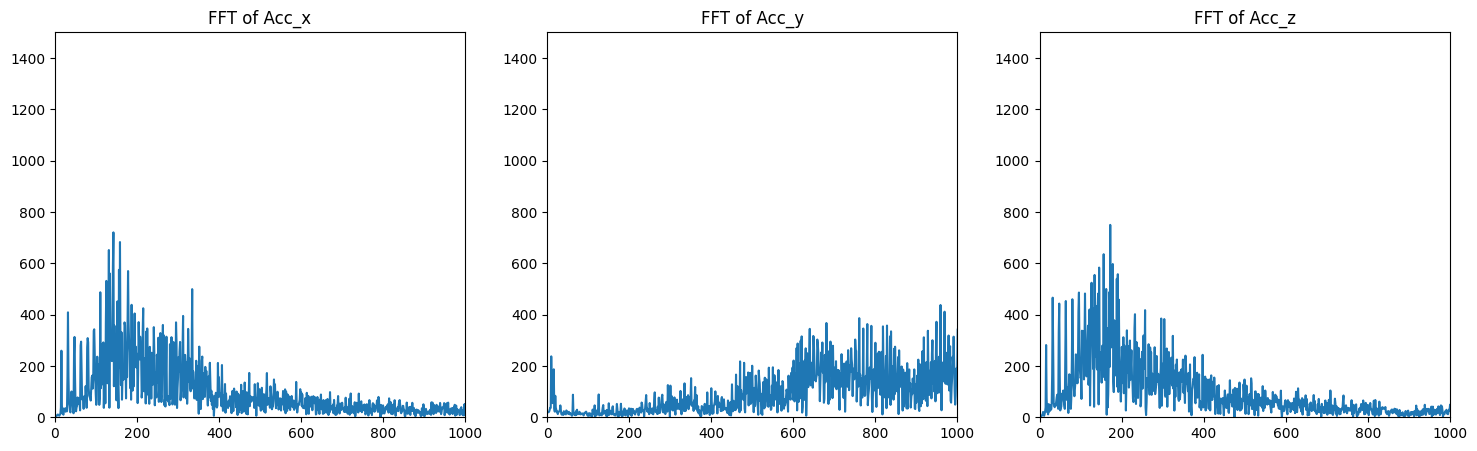

In [38]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_WOW2_MVA60_TQ.dfr')
#WOW2 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_WOW3_MVA60_TQ.dfr')
#WOW3 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_BOB1_MVA60_TQ.dfr')
#WOW3 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

In [ ]:
target = "TIE_ROD_R"
paths_list = ["Acceleration/X", "Acceleration/Y", "Acceleration/Z"]
install_path = os.environ['AWP_ROOT252']
file_path = os.path.join(install_path, r'C:\00_Project_ssd\JX_Assy\JX_deflector_angle_BOB2_MVA60_TQ.dfr')
#WOW3 결과임
FFT_start_time = 0.1
FFT_end_time = 1

analyze_acceleration_data(target, paths_list, file_path, FFT_start_time, FFT_end_time)

너트 토크를 8700 기준으로 하였을때
너트를 강제 변위 한 경우보다 실제와 경향이 맞지 않았음